# Project 242

## Import

In [328]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [329]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [330]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


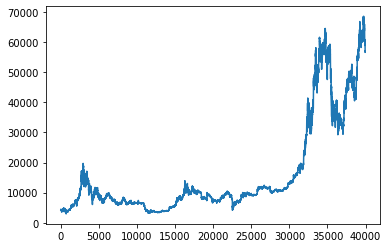

In [331]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [332]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})
data.columns

Index(['open', 'high', 'low', 'close', 'Volume'], dtype='object')

Here, we can decide to add features ...

In [333]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [334]:
data = data.drop(['VWAP'], axis = 1)

In [335]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 12) | X_test: (9978, 12)


In [336]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [337]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [338]:
# Add Signal
q_75 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.75)

train_data = add_signal(train_data, q_75)
test_data = add_signal(test_data, q_75)

In [339]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (13.0%) | 0 (75.0%) | -1 (12.0%)
Test set: 1 (19.0%) | 0 (65.0%) | -1 (16.0%)


In [340]:
#display(train_data.head(2))
test_data['Signal'].describe()

count    9978.000000
mean        0.020946
std         0.592004
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Signal, dtype: float64

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [341]:
train = prepare_data_2D_format(train_data)
test = prepare_data_2D_format(test_data, undersample = False)
test = test[:-10]

X_train = train
X_train = X_train.drop(['Signal'], axis = 1)
y_train = train['Signal']

X_test = test
X_test = X_test.drop(['Signal'], axis = 1)
y_test = test['Signal']

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [342]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# ccp_alpha values
grid_values = {'ccp_alpha': np.linspace(0, 0.0015, 30),
              'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]}

# Regression Tree
dtc = DecisionTreeClassifier()

# Regression Tree for all ccp_alpha
dtc_cv = GridSearchCV(dtc, param_grid=grid_values, scoring='accuracy', cv=5, verbose=1)
dtc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.00000000e+00, 5.17241379e-05, 1.03448276e-04, 1.55172414e-04,
       2.06896552e-04, 2.58620690e-04, 3.10344828e-04, 3.62068966e-04,
       4.13793103e-04, 4.65517241e-04, 5.17241379e-04, 5.68965517e-04,
       6.20689655e-04, 6.72413793e-04, 7.24137931e-04, 7.75862069e-04,
       8.27586207e-04, 8.79310345e-04, 9.31034483e-04, 9.82758621e-04,
       1.03448276e-03, 1.08620690e-03, 1.13793103e-03, 1.18965517e-03,
       1.24137931e-03, 1.29310345e-03, 1.34482759e-03, 1.39655172e-03,
       1.44827586e-03, 1.50000000e-03]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='accuracy', verbose=1)

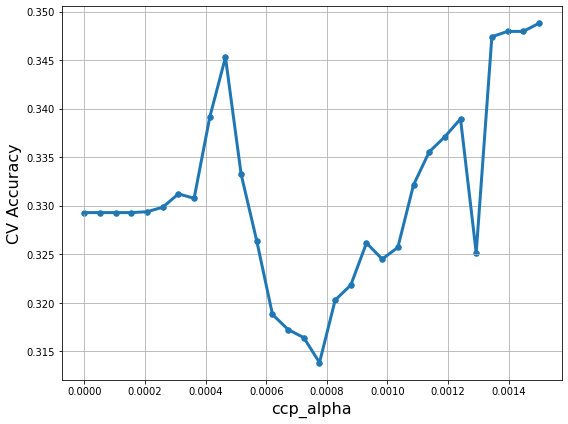

In [343]:
## The goal here is to plot accuracy scores with respect to ccp_alpha, to justify my choice
import matplotlib.pyplot as plt

acc_scores = dtc_cv.cv_results_['mean_test_score']
ccp_alpha = dtc_cv.cv_results_['param_ccp_alpha'].data

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.scatter(ccp_alpha,acc_scores, s=30)
plt.plot(ccp_alpha, acc_scores, linewidth=3)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

In [344]:
print('Best ccp_alpha: ', dtc_cv.best_params_['ccp_alpha'])
print('Best Accuracy: ', dtc_cv.best_score_)

Best ccp_alpha:  0.0015
Best Accuracy:  0.3487833856760672


Node count: 13


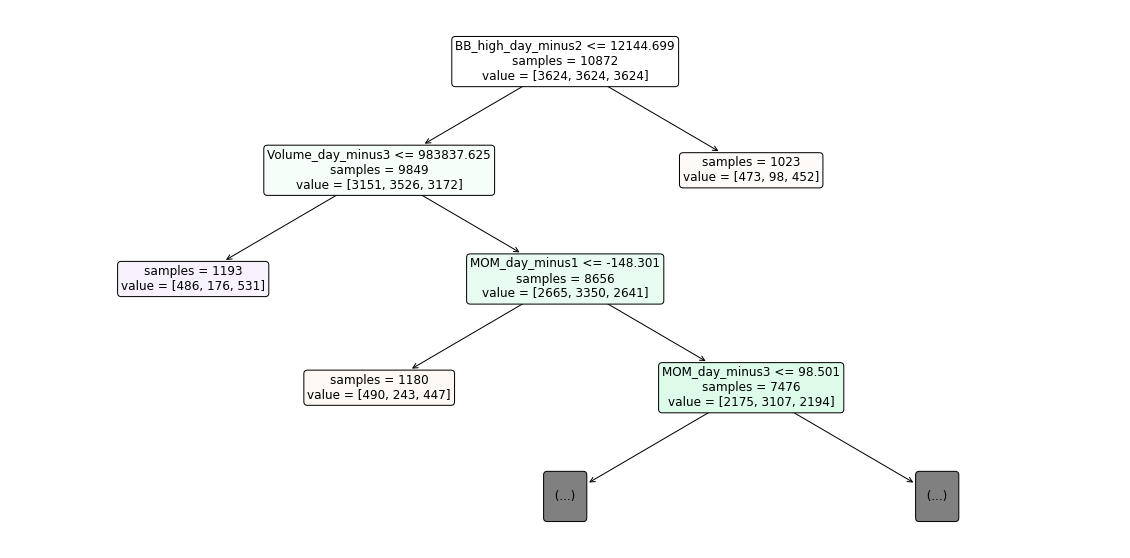

In [345]:
from sklearn.tree import plot_tree
print('Node count:', dtc_cv.best_estimator_.tree_.node_count)
plt.figure(figsize=(20,10))
plot_tree(dtc_cv.best_estimator_, feature_names=X_train.columns, filled=True,impurity=False, rounded=True,
        fontsize=12, max_depth=3)
plt.show()

In [346]:
y_pred = dtc_cv.best_estimator_.predict(X_test)

### 3. Test prediction model

In [347]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [348]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Baseline,0,0,0.165194,0,0


### III. Strategy

### 1. Get data ready for backtesting

In [349]:
# If the model used is a regression model on the return
#signal = get_signal(y_pred, alpha=q_90)

In [350]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

count    9958.0
mean       -1.0
std         0.0
min        -1.0
25%        -1.0
50%        -1.0
75%        -1.0
max        -1.0
dtype: float64

In [351]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [352]:
strat = Strategy(cash=500, fees=0.001)

In [353]:
strat.run(signal_crop, close_crop, verbose=False)

In [354]:
wallet = np.array(strat.wallet)
profit = wallet[:-1] - wallet[1:]

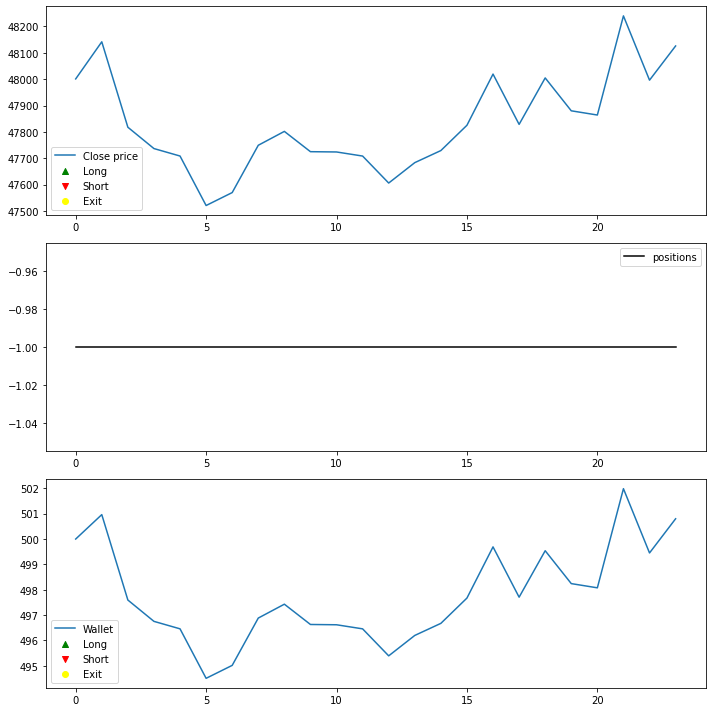

In [355]:
strat.visualize()

### 3. Test performance startegy

In [358]:
c_SharpeRatio = SharpeRatio(profit)
c_MaxDrawback = MaxDrawback(profit)
c_WinLossRatio = WinLossRatio(profit)
c_CumulativeProfit = CumulativeProfit(profit)
c_MeanProfit = MeanProfit(profit)

TypeError: 'numpy.float64' object is not callable

In [357]:
models = ['CART']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[c_SharpeRatio, c_MaxDrawback, c_WinLossRatio, c_CumulativeProfit, c_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
CART,-0.02086,-3.912356,1.090909,-0.799714,-0.033321
